# Statistics 504 - Fall 2015
## Title: " Exploring landslide severity across Washington using machine learning techniques"
### Class Project Proposal
### Erich Seamon
### erichs@uidaho.edu
### http://webpages.uidaho.edu/erichs


# Introduction and Overview of Dataset


The premise of this research will be to develop a set of models that effectively predict landslide severity, within the state of Washington, using geomorphic and landscape-driven feature variables, such as geology, soils, gradient, land-use, and previous landslide type.   <br>

Previous work by Ardizzone et al (2002), Ayalew and Yamagishi (2005), Ohlmacher and David (2003), all used logistical regression as a classifer method for landslide analysis. To expand upon this work, this project will evaluate several differing models to predict landslide severity:<br>

- logistical regression <br> 
- naive bayes <br>
- knn <br>
- random forest <br>
- decision tree <br>
- bagged decision tree <br>
- bagged random forest <br>


Under this approach, landslide explanatory variables will be trained on a training data set of an observed landslide locations, with thematic data such as morphometric attributes (gradient, slope morphology) as well as information on geology and landuse. 

The eventual goal will be to create a landslide model that is capable of returning a predictive result in the form of a geographic mapspace (essentially a prediction for each pixel).

## Data Sources

2007 and 2008 Landslide data for the state of Washington, containing over 52,000 observations, was accessed from the Washington Department of Natural Recreation (WA DNR). The data was provided as a downloadable .gdb file (geodatabase file).

http://www.dnr.wa.gov/publications/ger_portal_landslides_landforms.zip


## Data Transformation Before Analysis

The data was imported as a csv file - that was derived from the provided geodatabase file.  This csv file contained over 52,000 observations, with latitude and longitude included as well.  The csv file was transformed into a a pandas data frame, with text based categorical fields transformed to numeric values.  From this pandas data frame, our feature columns (X) and our response variable (y) were derived.

From the 52,000+ landslide observations, the number was reduced to:

#### 12,241

After eliminating records with NANs and other missing values needed for the analysis.

In [2]:
import PIL
from scipy import stats
import os,sys
import numpy as np
from PIL import Image
from urllib2 import urlopen

In [3]:

basewidth = 1100
img = Image.open(urlopen("http://webpages.uidaho.edu/erichs/dmine-data/Landslide_data_flow.jpg"))
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img.save("landslide_information_flow_refined.jpg")

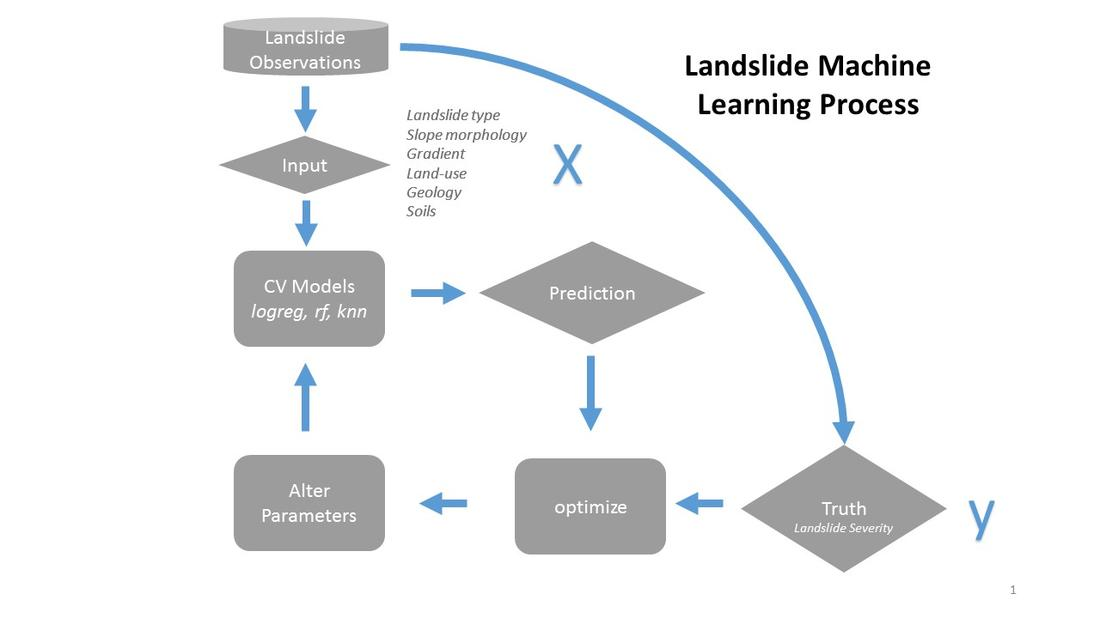

In [4]:
import os,sys
from PIL import Image
jpgfile = Image.open("landslide_information_flow_refined.jpg")
jpgfile

## Response and Feature Variables:

### Morphometric feature variables:

1) Slope Morphology Shape (SLOPE_MORP)   - Planar, Convex, Concave, etc. <br>
2) Land Use (LAND_USE)   - Forestry, Road/Rail/Trail, Undistubed, Urban Development <br>
3) Landslide Type (LANDSLIDE1)   - Debris Flows, Debris Slides and Avalanches, Shallow Undifferentiated, etc.<br>
4) Gradient (GRADIENT_D - transformed to gradient_cat)  - gradient of the landslide location, in degrees.<br>
5) Geology (GEOLOGIC_1) - geologic unit <br>
6) Soils (reacch_soi) - soils <br>

### Response Variable:

1) Landslide Severity (LANDSLID_3) - Low (0), Med (1) or High (2). <br>

Multiclass classification means a classification task with more than two classes. Multiclass classification makes the assumption that each sample is assigned to one and only one label.

# Preliminary Data Import and Analysis

In [23]:
import matplotlib
%matplotlib nbagg

from pyproj import Proj
import StringIO
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import pydot
from IPython.display import Image

from urllib2 import Request, urlopen
import json
from pandas.io.json import json_normalize
import numpy
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
%load_ext memory_profiler
from sklearn.ensemble import RandomForestClassifier

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Import csv file for all 52,000+WA landslides

In [5]:
import csv

In [21]:
walandslides_all = pd.read_csv('http://webpages.uidaho.edu/erichs/dmine-data/WALandslides_export4.csv')

In [22]:
walandslides = pd.read_csv('http://webpages.uidaho.edu/erichs/dmine-data/WALandslides.csv')

## Table of all values for initial landslide dataset

In [9]:
walandslides_allxy = [walandslides_all.OBJECTID, walandslides_all.POINT_X, walandslides_all.POINT_Y]
walandslides_allxy = pd.DataFrame(walandslides_allxy)
walandslides_allxy = walandslides_allxy.transpose()
walandslides = pd.DataFrame(walandslides)
walandslides = pd.merge(walandslides_allxy, walandslides, on='OBJECTID', how='outer')

## Set landslide type as numeric

In [10]:
stringh1 = set(walandslides.LANDSLIDE1)
J = list(stringh1)
J2 = list(range(1, 106))

In [11]:
i2 = iter(J)
j2 = iter(J2)
k2 = list(zip(i2, j2))
kdict2 = dict(k2)
kdict2.values()
walandslides['LANDSLIDE1'].replace(kdict2, inplace=True)
#print walandslides.LANDSLIDE1

## Convert categorical text columns to categorical numerical

In [12]:
walandslides['DATA_CONFI'] = walandslides.DATA_CONFI.map({'Low':0, 'Moderate-High':1})
walandslides['SLOPE_MORP'] = walandslides.SLOPE_MORP.map({'Planar':0, 'Concave-Planar':1, 'Concave, convergent':2, 'Planar-Concave':3, 'Planar-convex':4})
walandslides['LANDSLID_3'] = walandslides.LANDSLID_3.map({'Questionable':0, 'Probable':1, 'Certain':2, 'Unknown':3})

## Reduce dataset by eliminating NANs, set feature columns for X

In [13]:
walandslides = walandslides[np.isfinite(walandslides['SLOPE_MORP'])]
walandslides = walandslides[np.isfinite(walandslides['LANDSLIDE1'])]
walandslides = walandslides[walandslides.LANDSLID_3 != 3]
walandslides = walandslides[walandslides.GRADIENT_D != 0]
feature_cols = ['gradient_cat', 'GEOLOGIC_1', 'reacch_soi', 'LAND_USE', 'LANDSLIDE1', 'SLOPE_MORP']

## Convert GRADIENT_D to categorical, using quantiles

In [14]:
labelz = ["1", "2", "3", "4", "5"]
gradient = pd.DataFrame(walandslides.GRADIENT_D)
gradient = pd.DataFrame(pd.qcut(walandslides.GRADIENT_D, 5, labels = labelz))
gradient.rename(columns={'GRADIENT_D':'gradient_cat'}, inplace=True)
walandslides = pd.concat([walandslides, gradient], axis=1, join_axes=[gradient.index])

## Plot the refined WA landslides (~12000 landslide observations)

<IPython.core.display.Javascript object>


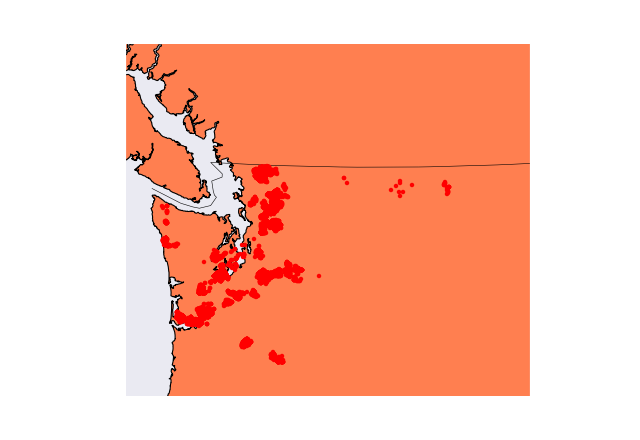

In [82]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
my_map2 = Basemap(llcrnrlon=-125, llcrnrlat=45, urcrnrlon=-115, urcrnrlat=51, projection='tmerc', lat_1=33, lat_2=45,
     lon_0=-119, lat_0=45, resolution='h', area_thresh=10000)
my_map2.drawcoastlines()
my_map2.drawcountries()
my_map2.fillcontinents(color='coral')
lon2 = np.array(walandslides.POINT_X)
lat2 = np.array(walandslides.POINT_Y)
y2,x2 = my_map2(lon2, lat2)
my_map2.plot(y2,x2, 'ro', markersize=4, markeredgecolor = 'k')
plt.show()

## Final X and y - reduced to a size of 12241 observations

In [16]:
walandslides['LAND_USE'] = walandslides.LAND_USE.map({'Forestry related activities':0, 'Undisturbed':1, 'Unknown':2, 'Urban development':3, 'Road, railroad, trail':4})

In [17]:
X = walandslides[feature_cols]
y = walandslides.LANDSLID_3
y = pd.concat([y], axis=1)
X[:5]

,gradient_cat,GEOLOGIC_1,reacch_soi,LAND_USE,LANDSLIDE1,SLOPE_MORP
1,3,29787,55856,4,12,0
2,5,33552,55805,4,3,4
4,1,32784,55804,4,12,0
5,4,30800,55837,4,3,0
6,3,30800,55837,3,12,0


### put X and y together for purpose of boxplots later

In [18]:
Xy = pd.concat([X, y], axis=1, join_axes=[X.index])

# Data Exploration

## Initial breakdown of gradient by degree (categorized)

In [19]:
gradient_pd = X['gradient_cat'].value_counts()
X['gradient_cat'].value_counts()

3    3044
2    2507
1    2464
5    2239
4    1987
dtype: int64

<IPython.core.display.Javascript object>


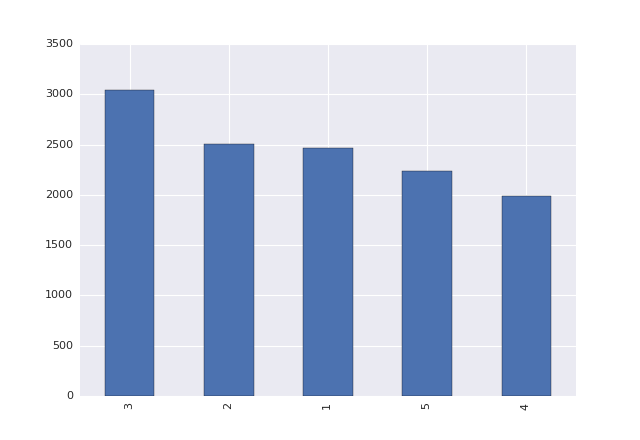

In [83]:
import matplotlib
%matplotlib nbagg
gradient_pd.plot(kind='bar');

### Initial breakdown of geology

In [21]:
geology_pd = X['GEOLOGIC_1'].value_counts()
geology_unique = pd.unique(X.GEOLOGIC_1.ravel())
geology_unique.shape

(907,)

<IPython.core.display.Javascript object>


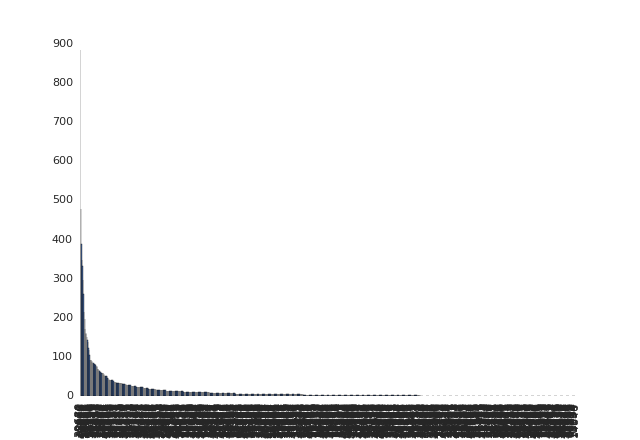

In [84]:
import matplotlib
%matplotlib nbagg
geology_pd.plot(kind='bar');

### Initial breakdown of soils

In [23]:
soils_pd = X['reacch_soi'].value_counts()
soils_unique = pd.unique(X.reacch_soi.ravel())
soils_unique.shape

(656,)

<IPython.core.display.Javascript object>


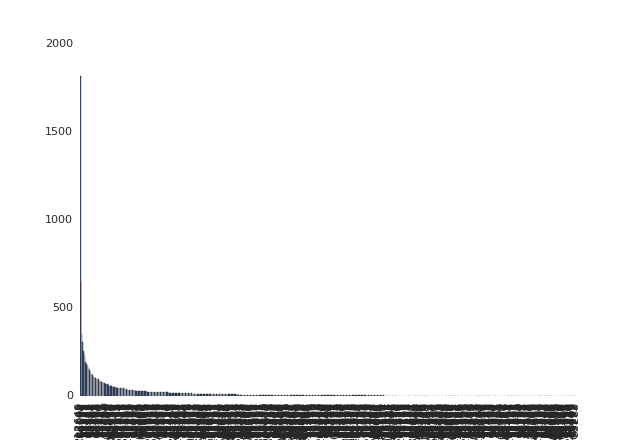

In [85]:
import matplotlib
%matplotlib nbagg
soils_pd.plot(kind='bar');

### Initial breakdown of slope morphology

In [25]:
slopemorp_pd = X['SLOPE_MORP'].value_counts()
X['SLOPE_MORP'].value_counts()

2    6526
0    5199
4     516
dtype: int64

<IPython.core.display.Javascript object>


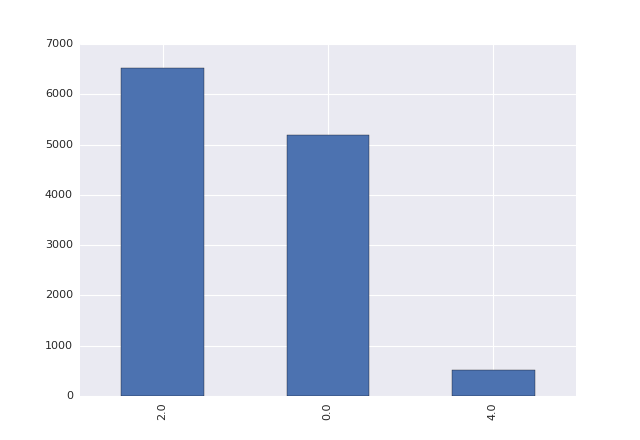

In [86]:
import matplotlib
%matplotlib nbagg
slopemorp_pd.plot(kind='bar');

### Initial breakdown of land use

In [27]:
landuse_pd = X['LAND_USE'].value_counts()
X['LAND_USE'].value_counts()

0    5981
2    3199
4    2479
1     529
3      53
dtype: int64

<IPython.core.display.Javascript object>


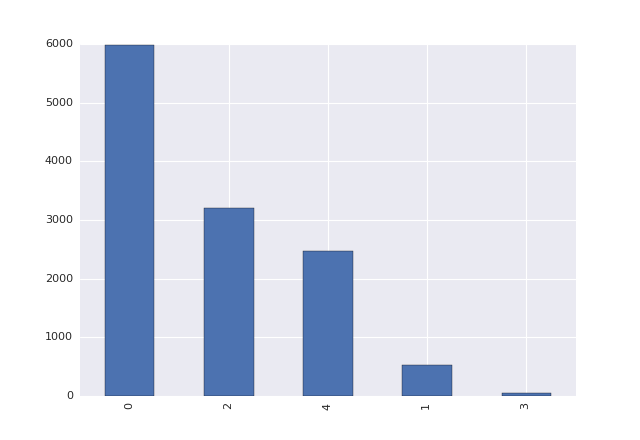

In [87]:
import matplotlib
%matplotlib nbagg
landuse_pd.plot(kind='bar');

### Initial breakdown of landslide type

In [29]:
landslidetype_pd = X['LANDSLIDE1'].value_counts()
X['LANDSLIDE1'].value_counts()

12    5496
11    2262
10    1913
3     1542
13     434
9      284
6      125
1      109
2       33
5       28
8       15
dtype: int64

<IPython.core.display.Javascript object>


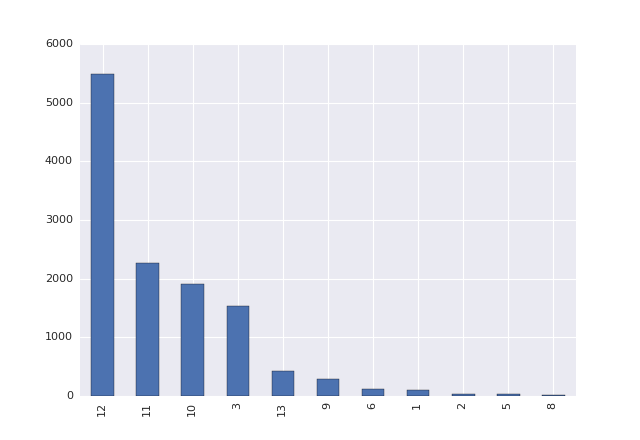

In [88]:
import matplotlib
%matplotlib nbagg
landslidetype_pd.plot(kind='bar');

### Response Variable - LANDSLID_3 - Landslide severity (0=Low, 1=Med, 3=High)

In [31]:
landslid3_pd = y['LANDSLID_3'].value_counts()
y['LANDSLID_3'].value_counts()

2    7501
1    3806
0     934
dtype: int64

<IPython.core.display.Javascript object>


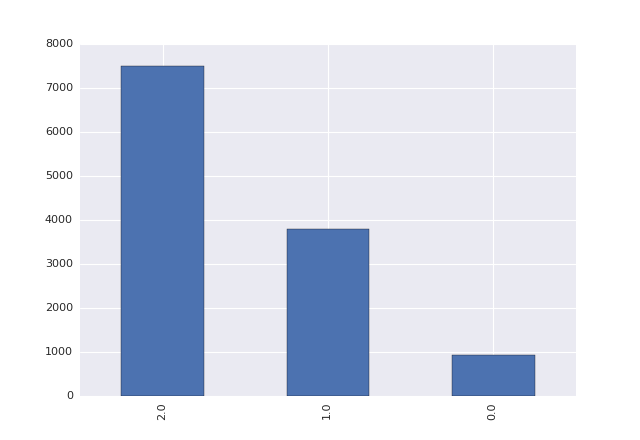

In [89]:
import matplotlib
%matplotlib nbagg
landslid3_pd.plot(kind='bar');

## run train test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

## Begin Model analysis

### Calculate Null Accuracy

In [34]:
import time
start = time.time()

nulltime1 = %%timeit -o 1 + 2
null = y_test['LANDSLID_3'].value_counts().head(1) / len(y_test['LANDSLID_3'])
print null

end = time.time()
nulltime1 = end - start
print nulltime1

10000000 loops, best of 3: 29.7 ns per loop
2    0.613198
dtype: float64
1.66566896439


## 10-fold cross-validation with logistic regression


In [35]:
y = np.ravel(y)

In [36]:
import time
start = time.time()

logregtime1 = %%timeit -o 1 + 2
#%%memit
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X,y)
logreg_scores_mean = cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
logregtime1 = end - start
print logregtime1

The slowest run took 40.07 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 29.8 ns per loop
3.05441808701


In [37]:
print logreg_scores_mean

0.612775243431


## Naive Bayes Multinomial

In [38]:
import time
start = time.time()

from sklearn.naive_bayes import MultinomialNB
nbm = MultinomialNB()
nbm.fit(X, y)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nbm_scores = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

end = time.time()
nbmtime1 = end - start
print nbmtime1

0.212238788605


In [39]:
nbm_mean_score = nbm_scores.mean()
print nbm_mean_score

0.401841069761


## 10-fold cross-validation with K Nearest Neighbor

In [40]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9)
#scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
knn_scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print knn_scores

[ 0.67918367  0.69444444  0.6870915   0.70179739  0.67973856  0.69689542
  0.69444444  0.69934641  0.69199346  0.70424837]


In [41]:
mean_score = knn_scores.mean()
print mean_score

0.692918367347


## Search for an optimal value of K for KNN

In [42]:
# search for an optimal value of K for KNN
k_range = range(1, 31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    k_scores.append(scores.mean())
print k_scores

[0.7251043083900226, 0.66154568494064292, 0.69234627184207009, 0.67706762705082035, 0.69920541549953319, 0.68678964919301055, 0.69577597705748961, 0.68662658396692022, 0.69259003601440572, 0.69160984393757508, 0.69528631452581036, 0.68932466319861274, 0.695858143257303, 0.69201880752300926, 0.69740949713218625, 0.68973042550353481, 0.69356989462451635, 0.69128384687208211, 0.69169187675070032, 0.69373436041083092, 0.68948599439775904, 0.68711698012538336, 0.68940589569160993, 0.68924229691876748, 0.68752320928371347, 0.68989455782312936, 0.68540302787781771, 0.68703561424569837, 0.68531966119781251, 0.68107036147792455]


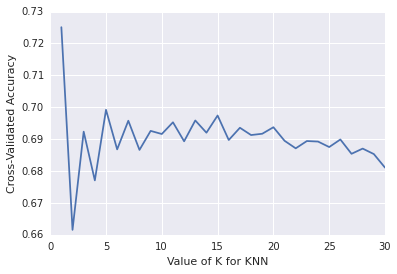

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Re-run KNN with an optimized k=1

In [44]:
import time
start = time.time()

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X,y)
knn_scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
knntime1 = end - start
print knntime1

0.402378082275


In [45]:
print knn_scores

0.724614712552


## Decision Tree - Fit a classification tree with an initial max_depth=3 on all data


In [46]:
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
scores = cross_val_score(treeclf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
treeclf.fit(X, y)
print scores.mean()

0.665875083367


## Decision Tree - search for an optimal gamma/depth for Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier
clf_range2 = range(1, 100)
clf_scores2 = []
for k in clf_range2:
    clf = DecisionTreeClassifier(max_depth=k)
    clfscores2 = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    clf_scores2.append(clfscores2.mean())
print clf_scores2

[0.64382072829131654, 0.65395044684540493, 0.66587741763372033, 0.67012525010004009, 0.67257469654528479, 0.6755991063091904, 0.67927571028411371, 0.6963478724823261, 0.69749059623849541, 0.70696938775510199, 0.70860250766973454, 0.71252347605708954, 0.72151007069494455, 0.71685347472322258, 0.72641116446578624, 0.72739155662264898, 0.72869821261838064, 0.72837148192610379, 0.73065986394557825, 0.73278611444577835, 0.73482626383886895, 0.7332734427104175, 0.73841990129385093, 0.73262218220621589, 0.73033159930638925, 0.73074223022542351, 0.73212931839402429, 0.72722689075630265, 0.7299238362011472, 0.72657469654528473, 0.73490529545151395, 0.7333548085901026, 0.73727390956382544, 0.72959837268240635, 0.73204748566093114, 0.73090409497132192, 0.73384573829531807, 0.73025196745364818, 0.7320498866213152, 0.7348259970654929, 0.7353155929038282, 0.73188482059490456, 0.73368240629585169, 0.73825603574763243, 0.73115059357076162, 0.73302894491129789, 0.73547819127651071, 0.73033373349339725,

### Decision Tree - Plot accuracy of cross validation runs vs. values of depth

<IPython.core.display.Javascript object>


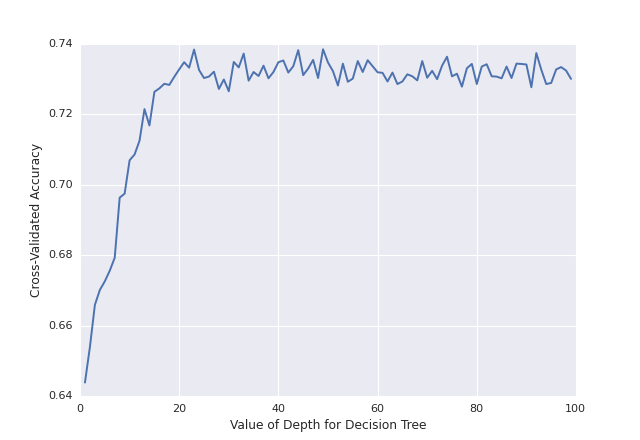

In [90]:
import matplotlib
%matplotlib nbagg
plt.plot(clf_range2, clf_scores2)
plt.xlabel('Value of Depth for Decision Tree')
plt.ylabel('Cross-Validated Accuracy')

## Decision Tree - Model optimization results:

After examining accuracy for a variety of depths, its appears that a value of ~41 for a max depth is optimal in terms of cross validation accuracy.

In [49]:
import time
start = time.time()

clftime1 = %%timeit -o 1 + 2
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=41, random_state=1)

treeclf_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
treeclf.fit(X, y)

end = time.time()
clftime1 = end - start
print clftime1

10000000 loops, best of 3: 29.7 ns per loop
1.77246594429


In [50]:
treeclf_scores_mean = treeclf_scores.mean()
print treeclf_scores_mean

0.735886954782


In [51]:
from StringIO import StringIO
tree_landslide = StringIO()

from sklearn.tree import DecisionTreeClassifier, export_graphviz
export_graphviz(treeclf, out_file=tree_landslide)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.179177 to fit



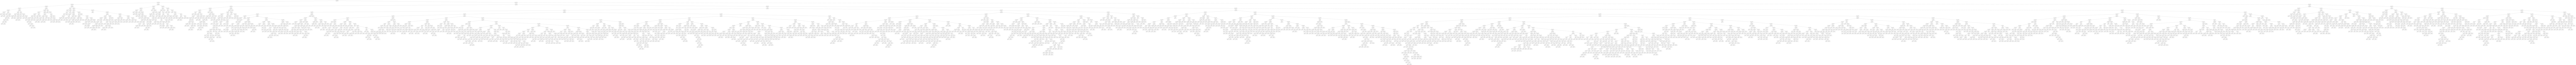

In [52]:
graph = pydot.graph_from_dot_data(tree_landslide.getvalue())  
Image(graph.create_png())

## Random Forest

In [55]:
rf_range = range(1, 100)
rf_scores = []
for k in rf_range:
    rfreg = RandomForestClassifier(n_estimators=k, random_state=42)
    rfa_scores = cross_val_score(rfreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    rf_scores.append(rfa_scores.mean())

<IPython.core.display.Javascript object>


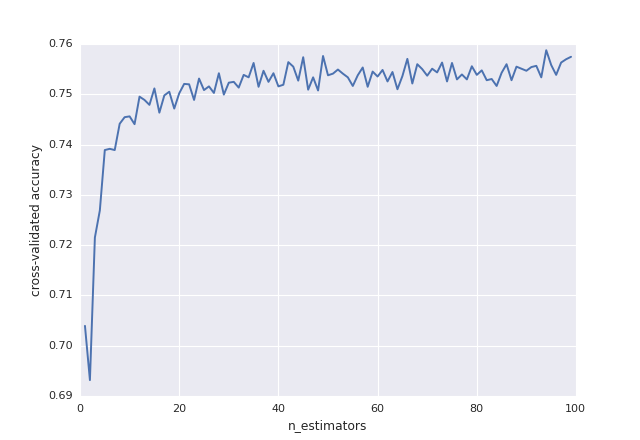

In [91]:
import matplotlib
%matplotlib nbagg
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(rf_range, rf_scores)
plt.xlabel('n_estimators')
plt.ylabel('cross-validated accuracy')

## Random Forest - List of values to try for max_features

In [57]:
feature_range = range(1, len(feature_cols)+1)
feature_scores = []
for feature in feature_range:
    rfreg = RandomForestClassifier(n_estimators=30, max_features=feature, random_state=1)
    featurea_scores = cross_val_score(rfreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    feature_scores.append(featurea_scores.mean())

<IPython.core.display.Javascript object>


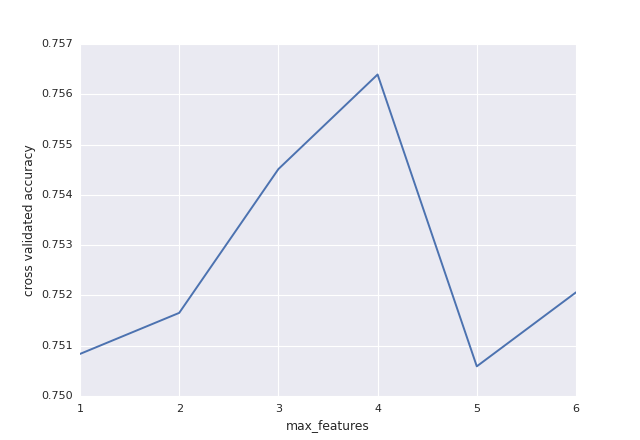

In [92]:
import matplotlib
%matplotlib nbagg
plt.plot(feature_range, feature_scores)
plt.xlabel('max_features')
plt.ylabel('cross validated accuracy')

## Re-run Random Forest with optimized settings

In [59]:
import time
start = time.time()

rfreg = RandomForestClassifier(n_estimators=20, max_features=4, oob_score=True, random_state=1)
rfreg.fit(X, y)
rfscores2_mean = cross_val_score(rfreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
rfregtime1 = end - start
print rfregtime1

5.01537394524


In [60]:
print rfscores2_mean

0.753287781779


## Random Forest and Feature Importance

In [61]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort('importance')

,feature,importance
3,LAND_USE,0.045154
5,SLOPE_MORP,0.069714
4,LANDSLIDE1,0.110858
0,gradient_cat,0.126600
2,reacch_soi,0.312409
1,GEOLOGIC_1,0.335266


In [62]:
# compute the out-of-bag R-squared score
rfreg.oob_score_

0.75018380851237643

## Setting a threshold on which features to include?

In [63]:
# set a threshold for which features to include
print rfreg.transform(X, threshold=0.1).shape
print rfreg.transform(X, threshold='mean').shape
print rfreg.transform(X, threshold='median').shape

(12241, 4)
(12241, 2)
(12241, 3)


In [64]:
# create a new feature matrix that only includes important features
X_important = rfreg.transform(X, threshold=0.1)

## Re-Run Random Forest with only 4 features - final optimized model

In [65]:
rfreg_opt = RandomForestClassifier(n_estimators=30, max_features=4, random_state=1)
rfreg_opt.fit(X,y)
scores = cross_val_score(rfreg_opt, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

In [66]:
print scores

0.755658263305


## Bootstrap aggregation of decision tree

In [67]:
bagclf2_scores = []
bagclf2_range = range(1, 20)
for k in bagclf2_range:
    bag_clf = BaggingClassifier(treeclf, n_estimators=k, max_samples=1.0, max_features=6, bootstrap = False, bootstrap_features = True, random_state=42)
    bag_clf.fit(X, y)
    bagclfa_scores = cross_val_score(bag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    bagclf2_scores.append(bagclfa_scores.mean())

<IPython.core.display.Javascript object>


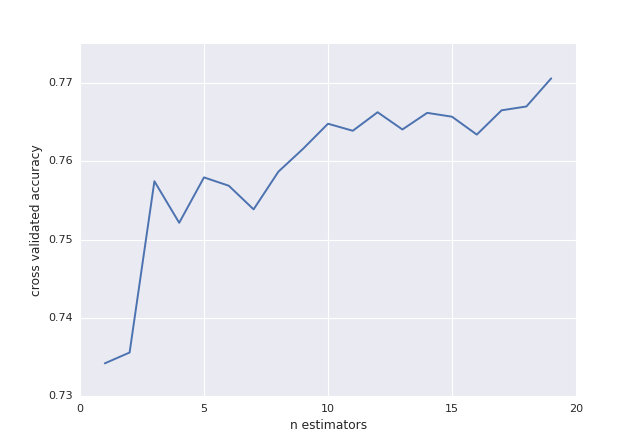

In [93]:
import matplotlib
%matplotlib nbagg
plt.plot(bagclf2_range, bagclf2_scores)
plt.xlabel('n estimators')
plt.ylabel('cross validated accuracy')

## Re-run bootstrap aggregation Decision Tree with optimized parameters

In [69]:
import time
start = time.time()

bag_clf_opt = BaggingClassifier(treeclf, n_estimators=16, max_samples=10000, max_features=6, bootstrap = False, bootstrap_features = True, random_state=42)
bag_clf_opt.fit(X, y)
bag_clf2_mean_scores = cross_val_score(bag_clf_opt, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
bagclftime1 = end - start
print bagclftime1

6.297976017


In [70]:
print bag_clf2_mean_scores

0.767341136455


## Bootstrap Aggregation using Random Forest - optimize estimators

In [71]:
bagrf_scores = []
bagrf_range = range(1, 20)
for k in bagrf_range:
    bag_clf = BaggingClassifier(rfreg, n_estimators=k, max_samples=10000, max_features=6, bootstrap = False, bootstrap_features = True, random_state=42)
    bag_clf.fit(X, y)
    bagrfa_scores = cross_val_score(bag_clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    bagrf_scores.append(bagrfa_scores.mean())

/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:379: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


<IPython.core.display.Javascript object>


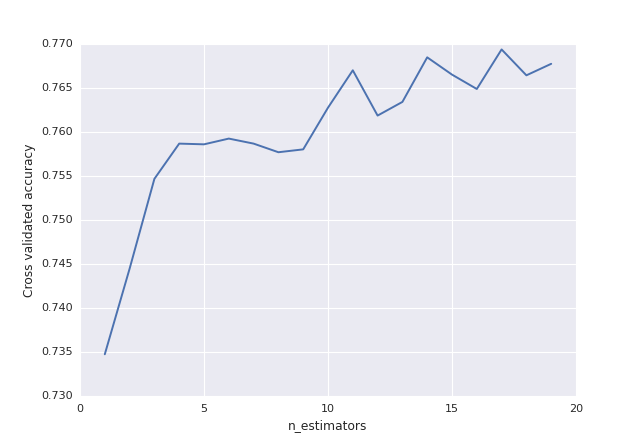

In [72]:
import matplotlib
%matplotlib nbagg
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(bagrf_range, bagrf_scores)
plt.xlabel('n_estimators')
plt.ylabel('Cross validated accuracy')

## Re-run Bootstrap Aggregation using Random Forest with optimized estimators

In [73]:
import time
start = time.time()

bagrf_clf_opt = BaggingClassifier(treeclf, n_estimators=20, max_samples=10000, max_features=6, bootstrap = False, bootstrap_features = True, random_state=42)
bagrf_clf_opt.fit(X, y)
bagrfr_scores = cross_val_score(bagrf_clf_opt, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
bagrftime1 = end - start
print bagrftime1

8.36749100685


In [74]:
print bagrfr_scores

0.766768907563


In [75]:
y = np.ravel(y)

# Results

In [76]:
#time1 = [nulltime1.best, nbmtime1.best, logregtime1.best, clftime1.best, bagclftime1.best, rfregtime1.best, bagrftime1.best]
time1 = [nulltime1, nbmtime1, logregtime1, knntime1, clftime1, rfregtime1, bagclftime1, bagrftime1]
time_name = ['null', 'naive bayes multinomial', 'logistical regression', 'KNN', 'Tree', 'Random Forest', 'Bagged Tree', 'Bagged Random Forest']
time_columns = ['time', 'Model']

##- convert time1 to zscore for normalization plot later

zscore_time1 = pd.Series(stats.zscore(time1))


seriestime1 = pd.Series(time1)
seriestime_name = pd.Series(time_name)
finaltime1 = pd.concat([seriestime1, seriestime_name], axis=1)
#print seriestime1
finaltime1.columns = time_columns
finaltime1 = finaltime1.time

## Results of Model Accuracy and Time

In [77]:
null = int(null)

In [78]:
#cv1 = [null, logreg_scores_mean, mean_score, knn_scores, treeclf_scores_mean, scores, bag_clf_scores, MSE_scores]
null = .613198
cv1 = [null, nbm_mean_score, logreg_scores_mean, knn_scores, treeclf_scores_mean, scores, bag_clf2_mean_scores,  bagrfr_scores]
cv_name = ['null', 'naive bayes M', 'log reg', 'KNN', 'Tree', 'RF', 'Bagged Tree', 'Bagged RF']
cv_columns = ['CV Accuracy', 'Model', 'Time']
cv_columnsonly = ['CV Accuracy', 'Model']
cv_columnstime = ['Time', 'Model']

##- convert cv1 to zscore for normalization plot later

zscore_cv1 = pd.Series(stats.zscore(cv1))

seriescv1 = pd.Series(cv1) 
seriescv_name = pd.Series(cv_name)
finalcv1 = pd.concat([seriescv1, seriescv_name], axis=1)

#print seriestime1
finalcv1.columns = cv_columnsonly
finalcv1only = finalcv1
finalcv1time = finalcv1
finalcv1time = pd.concat([finaltime1, seriescv_name], axis=1)
finalcv1time.columns = cv_columnstime

finalcv1 = pd.concat([finalcv1, zscore_time1], axis=1)
finalcv1.columns = cv_columns
finalcv1

,CV Accuracy,Model,Time
0,0.613198,null,-0.611504
1,0.401841,naive bayes M,-1.139647
2,0.612775,log reg,-0.106863
3,0.724615,KNN,-1.070555
4,0.735887,Tree,-0.572696
5,0.755658,RF,0.605704
6,0.767341,Bagged Tree,1.071773
7,0.766769,Bagged RF,1.823788


## Plot of Time for all Models

## Cross Validation Accuracy for all Models

<IPython.core.display.Javascript object>


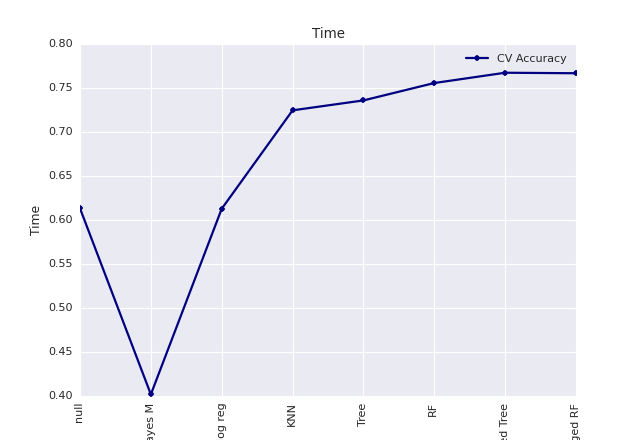

In [79]:
ax = finalcv1only.plot(x='Model', lw=2,colormap='jet',marker='.',markersize=10,title='Time', rot=90)
ax.set_xlabel("Models")
ax.set_ylabel("Time")

<IPython.core.display.Javascript object>


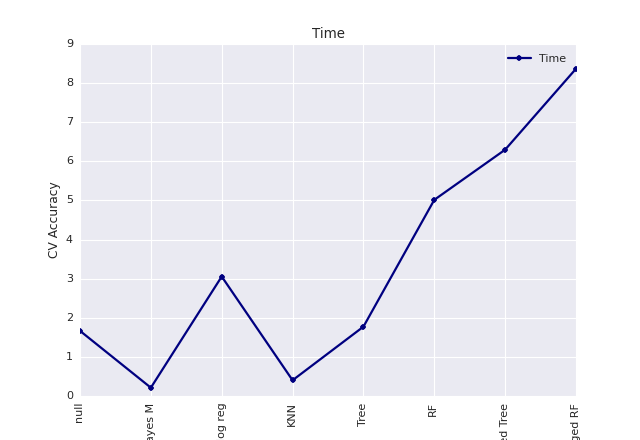

In [80]:
ax = finalcv1time.plot(x='Model', lw=2,colormap='jet',marker='.',markersize=10,title='Time', rot=90)
ax.set_xlabel("Models")
ax.set_ylabel("CV Accuracy")

## Plot of CV Accuracy AND time - for all Models - normalized using zscore

<IPython.core.display.Javascript object>


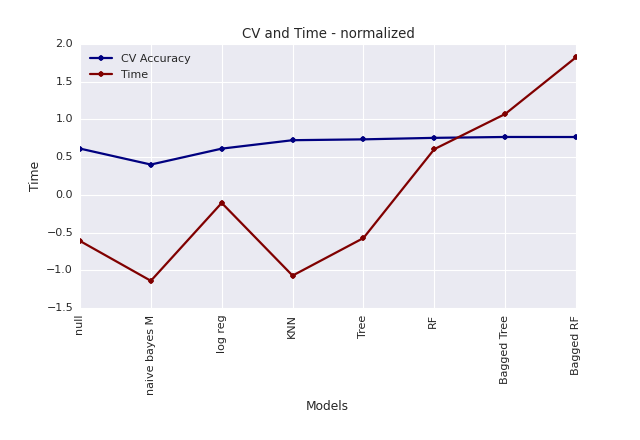

In [94]:
ax = finalcv1.plot(x='Model', lw=2,colormap='jet',marker='.',markersize=10,title='CV and Time - normalized', rot=90)
ax.set_xlabel("Models")
ax.set_ylabel("Time")

fig = plt.gcf()
fig.subplots_adjust(bottom=0.3)

plt.show()

# Conclusions

In review of the above results, Bagged Random Forest appears to have the best cross fold validation accuracy, at ~76%, with Bagged Tree and Random Forest being very close to that value.  Bagged Random Forest also appears to be the model that ran for the longest time.

KNN and Tree performed slightly better with regards to comparing time to accuracy - since both have low time performance, as well as accuracy that is close to the top model performer, RF.

An interesting aspect of this model is that it includes no climate data, which is certainly relevant with regards to a water-relevant climate risk process like landslides.  In model preparation, climate data averaged for a year for all sites was used, but performed very poorly.  A re-examiniation of this model might benefit from extracting climate data for the specific time frames for each landslide observation, or a set time period before the landslide occurance - to incorporate any possible trigger effects that precipitation may be causing.

A final feature variable that could be useful as well is earthquake occurrence.  It has been well established that earthquakes can incite landslides. As such, incorporation of earthquake hazard might improve the quality of this model.

In terms of response variable usage - a grouped 'low', 'med', and 'high' ranking may be too generized.  Other landslide datasets quantify landslide risk as a measure of cost - which might be a better response variable for prediction purposes.  Unsupervised analysis may also be useful - given the difficulty in quanifying the impact of landslides in a more cohesive, broad fashion.

